### Configure environment

In [31]:
from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager
fablib = fablib_manager() 
conf = fablib.show_config()

Credential Manager,cm.fabric-testbed.net
Orchestrator,orchestrator.fabric-testbed.net
Project ID,073ee843-2310-45bd-a01f-a15d808827dc
Token File,/home/fabric/.tokens.json
Bastion Host,bastion.fabric-testbed.net
Bastion Username,nm3833_0000195331
Bastion Private Key File,/home/fabric/work/fabric_config/fabric_bastion_key
Slice Private Key File,/home/fabric/work/fabric_config/slice_key
Slice Public Key File,/home/fabric/work/fabric_config/slice_key.pub
Log File,/tmp/fablib/fablib.log
Log Level,INFO


### Define configuration for this experiment

In [32]:
slice_name="re-when-to-use-bbr-" + fablib.get_bastion_username()

# use default_ubuntu_22 for 5.15 kernel, default_ubuntu_18 for 4.15 kernel, default_ubuntu_20 for BBRv2
image = 'default_ubuntu_22' 

node_conf = [
 {'name': "h1",  'cores': 4, 'ram': 16, 'disk': 500, 'image': image, 'packages': ['iperf3']}, 
 {'name': "h2",  'cores': 4, 'ram': 16, 'disk': 10, 'image': image, 'packages': ['iperf3']}, 
 {'name': "h3",  'cores': 4, 'ram': 16, 'disk': 10, 'image': image, 'packages': ['iperf3']}, 
 {'name': "tbf", 'cores': 8, 'ram': 32, 'disk': 10, 'image': image, 'packages': []} 
]
net_conf = [
 {"name": "link1", "subnet": "10.10.1.0/24", "nodes": [{"name": "tbf",   "addr": "10.10.1.10"}, {"name": "h1", "addr": "10.10.1.1"}]},
 {"name": "link2", "subnet": "10.10.2.0/24", "nodes": [{"name": "tbf",   "addr": "10.10.2.10"}, {"name": "h2", "addr": "10.10.2.1"}]},
 {"name": "link3", "subnet": "10.10.3.0/24", "nodes": [{"name": "tbf",   "addr": "10.10.3.10"}, {"name": "h3", "addr": "10.10.3.1"}]}
]
route_conf = [
 {"addr": "10.10.3.0/24", "gw": "10.10.1.10", "nodes": ["h1"]}, 
 {"addr": "10.10.3.0/24", "gw": "10.10.2.10", "nodes": ["h2"]},  
 {"addr": "10.10.1.0/24", "gw": "10.10.3.10", "nodes": ["h3"]},  
 {"addr": "10.10.2.0/24", "gw": "10.10.3.10", "nodes": ["h3"]}
]
exp_conf = {'cores': sum([ n['cores'] for n in node_conf]), 'nic': sum([len(n['nodes']) for n in net_conf]) }

### Reserve resources

Now, we are ready to reserve resources!

First, make sure you don’t already have a slice with this name:

In [33]:
try:
    slice = fablib.get_slice(slice_name)
    print("You already have a slice by this name!")
    print("If you previously reserved resources, skip to the 'log in to resources' section.")
except:
    print("You don't have a slice named %s yet." % slice_name)
    print("Continue to the next step to make one.")
    slice = fablib.new_slice(name=slice_name)

You don't have a slice named re-when-to-use-bbr-nm3833_0000195331 yet.
Continue to the next step to make one.


In [34]:
# slice.delete()

In [35]:
# while True:
#     site_name = fablib.get_random_site()
#     if ( (fablib.resources.get_core_available(site_name) > 1.2*exp_conf['cores']) and
#         (fablib.resources.get_component_available(site_name, 'SharedNIC-ConnectX-6') > 1.2**exp_conf['nic']) ):
#         break
site_name = 'EDUKY'
fablib.show_site(site_name)

Name,EDUKY
State,Active
Address,"301 Hilltop Avenue,Lexington, KY 40506"
Location,"(38.0325, -84.502801)"
PTP Capable,True
Hosts,18
CPUs,36
Cores Available,73462
Cores Capacity,73728
Cores Allocated,266
Ram Available,7852


'<pandas.io.formats.style.Styler object at 0x7a2742c055d0>'

Then we will add hosts and network segments:

In [36]:
# this cell sets up the nodes
for n in node_conf:
    slice.add_node(name=n['name'], site=site_name, 
                   cores=n['cores'], 
                   ram=n['ram'], 
                   disk=n['disk'], 
                   image=n['image'])

In [37]:
# this cell sets up the network segments
for n in net_conf:
    ifaces = [slice.get_node(node["name"]).add_component(model="NIC_Basic", 
                                                 name=n["name"]).get_interfaces()[0] for node in n['nodes'] ]
    slice.add_l2network(name=n["name"], type='L2Bridge', interfaces=ifaces)

The following cell submits our request to the FABRIC site. The output of this cell will update automatically as the status of our request changes.

-   While it is being prepared, the “State” of the slice will appear as “Configuring”.
-   When it is ready, the “State” of the slice will change to “StableOK”.

You may prefer to walk away and come back in a few minutes (for simple slices) or a few tens of minutes (for more complicated slices with many resources).

In [38]:
slice.submit()


Retry: 12, Time: 340 sec


ID,6da50f1c-5698-4ce8-8eee-23fdebc87608
Name,re-when-to-use-bbr-nm3833_0000195331
Lease Expiration (UTC),2024-08-03 16:22:25 +0000
Lease Start (UTC),2024-08-02 16:22:25 +0000
Project ID,073ee843-2310-45bd-a01f-a15d808827dc
State,StableOK


ID,Name,Cores,RAM,Disk,Image,Image Type,Host,Site,Username,Management IP,State,Error,SSH Command,Public SSH Key File,Private SSH Key File
ad79e6b7-04cf-49d6-b2ed-4aa0e7ab1d8e,h1,4,16,500,default_ubuntu_22,qcow2,eduky-w15.fabric-testbed.net,EDUKY,ubuntu,2610:1e0:1700:206:f816:3eff:feaf:81bd,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:1e0:1700:206:f816:3eff:feaf:81bd,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
2d2d8393-2f38-443e-bae6-0df70da4ca6f,h2,4,16,10,default_ubuntu_22,qcow2,eduky-w15.fabric-testbed.net,EDUKY,ubuntu,2610:1e0:1700:206:f816:3eff:fe02:6efa,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:1e0:1700:206:f816:3eff:fe02:6efa,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
d9d2f65a-461b-4f8c-b03b-3d6e82a85fbc,h3,4,16,10,default_ubuntu_22,qcow2,eduky-w3.fabric-testbed.net,EDUKY,ubuntu,2610:1e0:1700:206:f816:3eff:fe3d:9609,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:1e0:1700:206:f816:3eff:fe3d:9609,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
b27dea62-41e2-47e2-8a12-b50e0faf471e,tbf,8,32,10,default_ubuntu_22,qcow2,eduky-w12.fabric-testbed.net,EDUKY,ubuntu,2610:1e0:1700:206:f816:3eff:fe2f:b83f,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:1e0:1700:206:f816:3eff:fe2f:b83f,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key


ID,Name,Layer,Type,Site,Subnet,Gateway,State,Error
5e08834e-3bf3-4d31-b27e-8d1423805866,link1,L2,L2Bridge,EDUKY,None,None,Active,
ec6b28fc-875c-4fb5-b797-7d178b126fbe,link2,L2,L2Bridge,EDUKY,None,None,Active,
937652c0-3479-4059-8d1d-e4d6cc471fbc,link3,L2,L2Bridge,EDUKY,None,None,Active,


Name,Short Name,Node,Network,Bandwidth,Mode,VLAN,MAC,Physical Device,Device,IP Address,Numa Node,Switch Port
h1-link1-p1,p1,h1,link1,100,config,,02:05:D6:28:EE:72,enp7s0,enp7s0,fe80::5:d6ff:fe28:ee72,1,HundredGigE0/0/0/15
h2-link2-p1,p1,h2,link2,100,config,,02:BF:18:44:8C:33,enp7s0,enp7s0,fe80::bf:18ff:fe44:8c33,1,HundredGigE0/0/0/15
h3-link3-p1,p1,h3,link3,100,config,,0A:34:85:20:F1:F6,enp7s0,enp7s0,fe80::834:85ff:fe20:f1f6,1,HundredGigE0/0/0/21
tbf-link2-p1,p1,tbf,link2,100,config,,02:AB:E6:22:3F:1A,enp8s0,enp8s0,fe80::ab:e6ff:fe22:3f1a,1,HundredGigE0/0/0/12
tbf-link3-p1,p1,tbf,link3,100,config,,02:DF:EB:82:04:AD,enp9s0,enp9s0,fe80::df:ebff:fe82:4ad,1,HundredGigE0/0/0/12
tbf-link1-p1,p1,tbf,link1,100,config,,02:81:65:37:2B:6A,enp7s0,enp7s0,fe80::81:65ff:fe37:2b6a,1,HundredGigE0/0/0/12



Time to print interfaces 368 seconds


'6da50f1c-5698-4ce8-8eee-23fdebc87608'

In [39]:
slice.get_state()
slice.wait_ssh(progress=True)

Waiting for slice . Slice state: StableOK
Waiting for ssh in slice . ssh successful


True

### Extend slice for one week

In [40]:
from datetime import datetime
from datetime import timezone
from datetime import timedelta

# Set end date to 7 days from now
end_date = (datetime.now(timezone.utc) + timedelta(days=7)).strftime("%Y-%m-%d %H:%M:%S %z")
slice.renew(end_date)


Retry: 1, Time: 95 sec


ID,6da50f1c-5698-4ce8-8eee-23fdebc87608
Name,re-when-to-use-bbr-nm3833_0000195331
Lease Expiration (UTC),2024-08-08 16:28:44 +0000
Lease Start (UTC),2024-08-02 16:22:25 +0000
Project ID,073ee843-2310-45bd-a01f-a15d808827dc
State,StableOK


ID,Name,Cores,RAM,Disk,Image,Image Type,Host,Site,Username,Management IP,State,Error,SSH Command,Public SSH Key File,Private SSH Key File
ad79e6b7-04cf-49d6-b2ed-4aa0e7ab1d8e,h1,4,16,500,default_ubuntu_22,qcow2,eduky-w15.fabric-testbed.net,EDUKY,ubuntu,2610:1e0:1700:206:f816:3eff:feaf:81bd,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:1e0:1700:206:f816:3eff:feaf:81bd,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
2d2d8393-2f38-443e-bae6-0df70da4ca6f,h2,4,16,10,default_ubuntu_22,qcow2,eduky-w15.fabric-testbed.net,EDUKY,ubuntu,2610:1e0:1700:206:f816:3eff:fe02:6efa,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:1e0:1700:206:f816:3eff:fe02:6efa,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
d9d2f65a-461b-4f8c-b03b-3d6e82a85fbc,h3,4,16,10,default_ubuntu_22,qcow2,eduky-w3.fabric-testbed.net,EDUKY,ubuntu,2610:1e0:1700:206:f816:3eff:fe3d:9609,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:1e0:1700:206:f816:3eff:fe3d:9609,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
b27dea62-41e2-47e2-8a12-b50e0faf471e,tbf,8,32,10,default_ubuntu_22,qcow2,eduky-w12.fabric-testbed.net,EDUKY,ubuntu,2610:1e0:1700:206:f816:3eff:fe2f:b83f,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:1e0:1700:206:f816:3eff:fe2f:b83f,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key


ID,Name,Layer,Type,Site,Subnet,Gateway,State,Error
5e08834e-3bf3-4d31-b27e-8d1423805866,link1,L2,L2Bridge,EDUKY,None,None,Active,
ec6b28fc-875c-4fb5-b797-7d178b126fbe,link2,L2,L2Bridge,EDUKY,None,None,Active,
937652c0-3479-4059-8d1d-e4d6cc471fbc,link3,L2,L2Bridge,EDUKY,None,None,Active,


Name,Short Name,Node,Network,Bandwidth,Mode,VLAN,MAC,Physical Device,Device,IP Address,Numa Node,Switch Port
h1-link1-p1,p1,h1,link1,100,config,,02:05:D6:28:EE:72,enp7s0,enp7s0,fe80::5:d6ff:fe28:ee72,1,HundredGigE0/0/0/15
h2-link2-p1,p1,h2,link2,100,config,,02:BF:18:44:8C:33,enp7s0,enp7s0,fe80::bf:18ff:fe44:8c33,1,HundredGigE0/0/0/15
h3-link3-p1,p1,h3,link3,100,config,,0A:34:85:20:F1:F6,enp7s0,enp7s0,fe80::834:85ff:fe20:f1f6,1,HundredGigE0/0/0/21
tbf-link2-p1,p1,tbf,link2,100,config,,02:AB:E6:22:3F:1A,enp8s0,enp8s0,fe80::ab:e6ff:fe22:3f1a,1,HundredGigE0/0/0/12
tbf-link3-p1,p1,tbf,link3,100,config,,02:DF:EB:82:04:AD,enp9s0,enp9s0,fe80::df:ebff:fe82:4ad,1,HundredGigE0/0/0/12
tbf-link1-p1,p1,tbf,link1,100,config,,02:81:65:37:2B:6A,enp7s0,enp7s0,fe80::81:65ff:fe37:2b6a,1,HundredGigE0/0/0/12



Time to print interfaces 123 seconds


In [41]:
slice.update()
_ = slice.show()

ID,6da50f1c-5698-4ce8-8eee-23fdebc87608
Name,re-when-to-use-bbr-nm3833_0000195331
Lease Expiration (UTC),2024-08-08 16:28:44 +0000
Lease Start (UTC),2024-08-02 16:22:25 +0000
Project ID,073ee843-2310-45bd-a01f-a15d808827dc
State,StableOK


### Extra configuration for this experiment

In [42]:
# set socket read and write buffer on all endpoints to larger value
for node in slice.get_nodes():
    node.execute("sudo sysctl -w net.core.rmem_default=2147483647")
    node.execute("sudo sysctl -w net.core.wmem_default=2147483647")
    node.execute("sudo sysctl -w net.core.rmem_max=2147483647")
    node.execute("sudo sysctl -w net.core.wmem_max=2147483647")

net.core.rmem_default = 2147483647
net.core.wmem_default = 2147483647
net.core.rmem_max = 2147483647
net.core.wmem_max = 2147483647
net.core.rmem_default = 2147483647
net.core.wmem_default = 2147483647
net.core.rmem_max = 2147483647
net.core.wmem_max = 2147483647
net.core.rmem_default = 2147483647
net.core.wmem_default = 2147483647
net.core.rmem_max = 2147483647
net.core.wmem_max = 2147483647
net.core.rmem_default = 2147483647
net.core.wmem_default = 2147483647
net.core.rmem_max = 2147483647
net.core.wmem_max = 2147483647


### Configure resources

Next, we will configure the resources so they are ready to use.

In [43]:
slice = fablib.get_slice(name=slice_name)

In [44]:
# install packages
# this will take a while and will run in background while you do other steps
for n in node_conf:
    if len(n['packages']):
        node = slice.get_node(n['name'])
        pkg = " ".join(n['packages'])
        node.execute_thread("sudo apt update; sudo apt -y install %s" % pkg)

In [45]:
#turn off segmentation offload on interfaces
for iface in slice.get_interfaces():
    iface_name = iface.get_device_name()
    n = iface.get_node()
    offloads = ['gro', 'lro', 'gso', 'tso']
    for offload in offloads:
        n.execute("sudo ethtool -K %s %s off" % (iface_name, offload))

In [46]:
# bring interfaces up and either assign an address (if there is one) or flush address
from ipaddress import ip_address, IPv4Address, IPv4Network

for net in net_conf:
    for n in net['nodes']:
        if_name = n['name'] + '-' + net['name'] + '-p1'
        iface = slice.get_interface(if_name)
        iface.ip_link_up()
        if n['addr']:
            iface.ip_addr_add(addr=n['addr'], subnet=IPv4Network(net['subnet']))
        else:
            iface.get_node().execute("sudo ip addr flush dev %s"  % iface.get_device_name())

In [47]:
# prepare a "hosts" file that has names and addresses of every node
hosts_txt = [ "%s\t%s" % ( n['addr'], n['name'] ) for net in net_conf  for n in net['nodes'] if type(n) is dict and n['addr']]
for n in slice.get_nodes():
    for h in hosts_txt:
        n.execute("echo %s | sudo tee -a /etc/hosts" % h)

10.10.1.10 tbf
10.10.1.1 h1
10.10.2.10 tbf
10.10.2.1 h2
10.10.3.10 tbf
10.10.3.1 h3
10.10.1.10 tbf
10.10.1.1 h1
10.10.2.10 tbf
10.10.2.1 h2
10.10.3.10 tbf
10.10.3.1 h3
10.10.1.10 tbf
10.10.1.1 h1
10.10.2.10 tbf
10.10.2.1 h2
10.10.3.10 tbf
10.10.3.1 h3
10.10.1.10 tbf
10.10.1.1 h1
10.10.2.10 tbf
10.10.2.1 h2
10.10.3.10 tbf
10.10.3.1 h3


In [48]:
# enable IPv4 forwarding on all nodes
for n in slice.get_nodes():
    n.execute("sudo sysctl -w net.ipv4.ip_forward=1")

net.ipv4.ip_forward = 1
net.ipv4.ip_forward = 1
net.ipv4.ip_forward = 1
net.ipv4.ip_forward = 1


In [49]:
# set up static routes
for rt in route_conf:
    for n in rt['nodes']:
        slice.get_node(name=n).ip_route_add(subnet=IPv4Network(rt['addr']), gateway=rt['gw'])

Install iperf3 on sender and reciver nodes

In [50]:
sender_node = slice.get_node(name='h1')
receiver_node = slice.get_node(name='h2')

In [51]:
sender_node.execute_thread('sudo apt update; sudo apt -y install iperf3')
receiver_node.execute_thread('sudo apt update; sudo apt -y install iperf3')

<Future at 0x7a274354e510 state=pending>

### Draw Topology

In [52]:
l2_nets = [(n.get_name(), {'color': 'lavender'}) for n in slice.get_l2networks() ]
l3_nets = [(n.get_name(), {'color': 'pink'}) for n in slice.get_l3networks() ]
hosts   =   [(n.get_name(), {'color': 'lightblue'}) for n in slice.get_nodes()]
nodes = l2_nets + l3_nets + hosts
ifaces = [iface.toDict() for iface in slice.get_interfaces()]
edges = [(iface['network'], iface['node'], 
          {'label': iface['physical_dev'] + '\n' + iface['ip_addr'] + '\n' + iface['mac']}) for iface in ifaces]

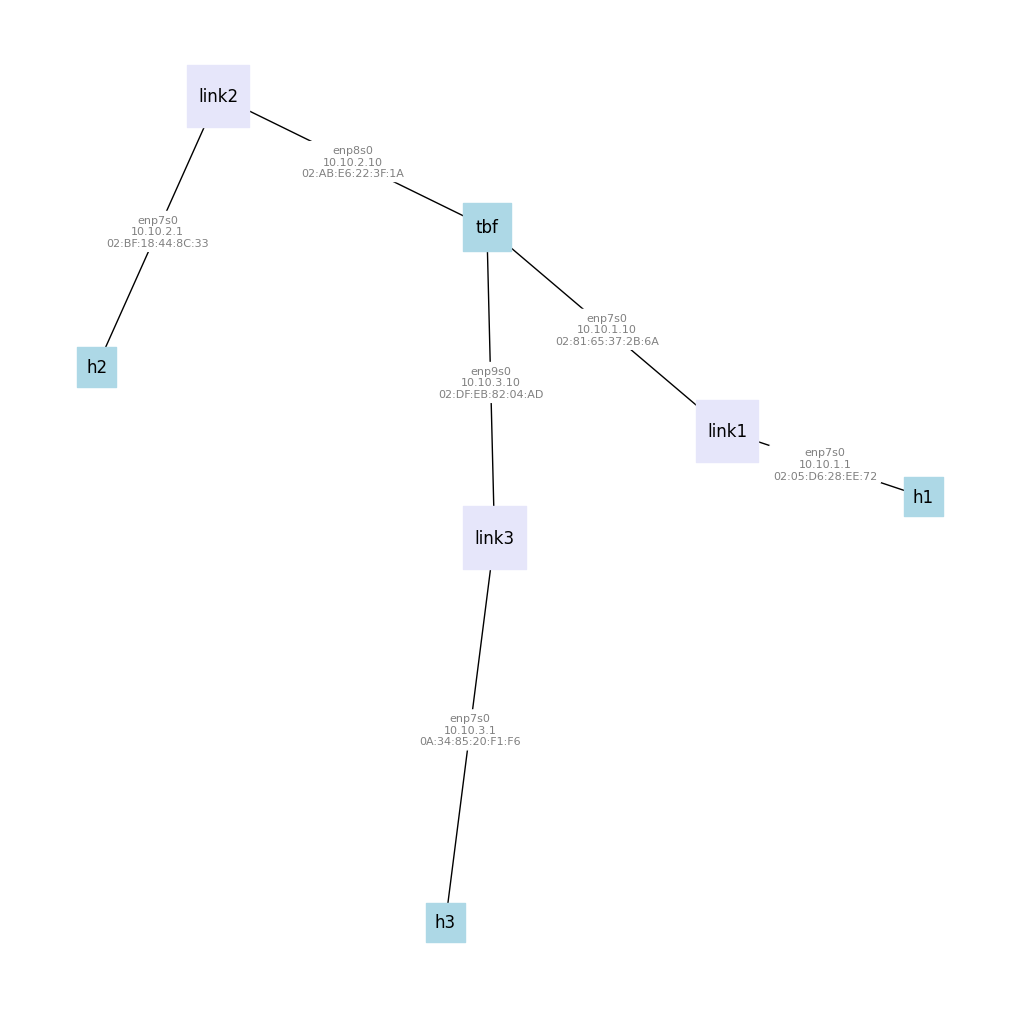

In [53]:
import networkx as nx
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 10))
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
pos = nx.spring_layout(G, k=1)  # Adjust the 'k' value to space out the nodes

nx.draw(G, pos, node_shape='s',  
        node_color=[n[1]['color'] for n in nodes], 
        node_size=[len(n[0])*400 for n in nodes],  
        with_labels=True)

nx.draw_networkx_edge_labels(G, pos,
                             edge_labels=nx.get_edge_attributes(G, 'label'),
                             font_color='gray', font_size=8, rotate=False)

plt.show()


## Check network capacity

We should get close to 25 Gbps (probably more like 23 Gbps because of protocol overhead) through the router.

First, make sure there is no rate limiting at the router - don't worry if you get an error message, this just means there was already no rate limiting.

In [7]:
router_node.execute("sudo tc qdisc del dev " + router_egress_name + " root")

('', '')

Now start the `iperf3` flows:

In [8]:
for n in receiver_nodes:
    n.execute("iperf3 -s -1 -D --logfile validate.dat")

In [9]:
import time
for n in sender_nodes:
    n.execute_thread("iperf3 -t 60 -P 10 -c 10.10.2.1$(hostname | cut -d'-' -f2)")
time.sleep(65)

In [10]:
tputs = []
for n in receiver_nodes:
    (nout, nerr) = n.execute("tail --lines=2 validate.dat | grep receiver | awk '{print $6}'")
    tputs.append(float(nout.strip()))
print("Sum throughput is: %f Gbps" % sum(tputs))

2.91
6.05
Sum throughput is: 8.960000 Gbps


A single pair of endpoints should be able to get about 10 Gbps, possibly higher.

In [28]:
receiver_nodes[0].execute("iperf3 -s -1 -f g -D")
sender_nodes[0].execute("iperf3 -t 60 -i 60 -P 10 -c 10.10.2.1$(hostname | cut -d'-' -f2)")

Connecting to host 10.10.2.10, port 5201
[  4] local 10.10.1.10 port 34552 connected to 10.10.2.10 port 5201
[  6] local 10.10.1.10 port 34560 connected to 10.10.2.10 port 5201
[  8] local 10.10.1.10 port 34562 connected to 10.10.2.10 port 5201
[ 10] local 10.10.1.10 port 34568 connected to 10.10.2.10 port 5201
[ 12] local 10.10.1.10 port 34574 connected to 10.10.2.10 port 5201
[ 14] local 10.10.1.10 port 34578 connected to 10.10.2.10 port 5201
[ 16] local 10.10.1.10 port 34586 connected to 10.10.2.10 port 5201
[ 18] local 10.10.1.10 port 34600 connected to 10.10.2.10 port 5201
[ 20] local 10.10.1.10 port 34604 connected to 10.10.2.10 port 5201
[ 22] local 10.10.1.10 port 34612 connected to 10.10.2.10 port 5201
[ ID] Interval           Transfer     Bandwidth       Retr  Cwnd
[  4]   0.00-60.00  sec  7.24 GBytes  1.04 Gbits/sec  1907   1.65 MBytes       
[  6]   0.00-60.00  sec  4.91 GBytes   703 Mbits/sec  1544    795 KBytes       
[  8]   0.00-60.00  sec  6.59 GBytes   943 Mbits/sec  

('Connecting to host 10.10.2.10, port 5201\n[  4] local 10.10.1.10 port 34552 connected to 10.10.2.10 port 5201\n[  6] local 10.10.1.10 port 34560 connected to 10.10.2.10 port 5201\n[  8] local 10.10.1.10 port 34562 connected to 10.10.2.10 port 5201\n[ 10] local 10.10.1.10 port 34568 connected to 10.10.2.10 port 5201\n[ 12] local 10.10.1.10 port 34574 connected to 10.10.2.10 port 5201\n[ 14] local 10.10.1.10 port 34578 connected to 10.10.2.10 port 5201\n[ 16] local 10.10.1.10 port 34586 connected to 10.10.2.10 port 5201\n[ 18] local 10.10.1.10 port 34600 connected to 10.10.2.10 port 5201\n[ 20] local 10.10.1.10 port 34604 connected to 10.10.2.10 port 5201\n[ 22] local 10.10.1.10 port 34612 connected to 10.10.2.10 port 5201\n[ ID] Interval           Transfer     Bandwidth       Retr  Cwnd\n[  4]   0.00-60.00  sec  7.24 GBytes  1.04 Gbits/sec  1907   1.65 MBytes       \n[  6]   0.00-60.00  sec  4.91 GBytes   703 Mbits/sec  1544    795 KBytes       \n[  8]   0.00-60.00  sec  6.59 GBytes  

## Check network delay

We should get sub-ms latency across the router.

In [30]:
for n in sender_nodes:
    n.execute("ping -c 5 10.10.2.1$(hostname | cut -d'-' -f2) | grep rtt")

rtt min/avg/max/mdev = 10.128/10.172/10.273/0.137 ms
rtt min/avg/max/mdev = 10.120/10.184/10.341/0.102 ms
